In [1]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [2]:
cwfis_perims = gpd.read_file("/projects/old_shared/fire_weather_vis/Lightning_analysis/CWFIS/perim_progression/progression.shp")

In [3]:
#cwfis_perims = cwfis_perims.set_crs("EPSG:4326")


In [4]:
cwfis_perims[1:4].explore()

In [5]:
cwfis_perims.columns

Index(['CLUSTERID', 'DATE', 'AREA', 'C_AREA', 'FWI', 'CONSIS_ID', 'geometry'], dtype='object')

In [6]:
import seaborn as sn

In [7]:
cwfis_perims.DATE

0        20230419.0
1        20230420.0
2        20230428.0
3        20230428.0
4        20230803.0
            ...    
12535    20231004.0
12536    20231009.0
12537    20231009.0
12538    20231009.0
12539    20231009.0
Name: DATE, Length: 12540, dtype: float64

[Text(0.5, 23.52222222222222, ''), Text(50.722222222222214, 0.5, '')]

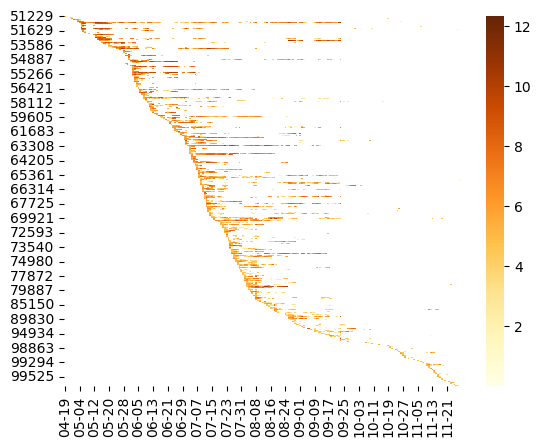

In [8]:
cwfis_perims["log_area"] = np.log(cwfis_perims.AREA)
cwfis_perims["better_format_date"] = pd.to_datetime(cwfis_perims.DATE.astype("str"), format="%Y%m%d.0")
#cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")

heat = cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2"]].pivot(index="CONSIS_ID", columns="better_format_date2", values="log_area")
ax = sn.heatmap(heat, cmap = "YlOrBr")
ax.set(xlabel="", ylabel="")

[Text(0.5, 23.52222222222222, ''), Text(50.722222222222214, 0.5, '')]

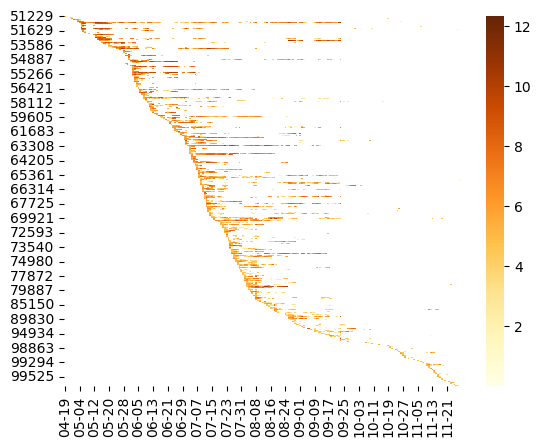

In [9]:
### Sort by lattitude 

cwfis_perims["x_component"] = cwfis_perims.geometry.centroid.x
cwfis_perims["y_component"] = cwfis_perims.geometry.centroid.y

cwfis_perims = cwfis_perims.sort_values(by = "y_component")



cwfis_perims["log_area"] = np.log(cwfis_perims.AREA)
cwfis_perims["better_format_date"] = pd.to_datetime(cwfis_perims.DATE.astype("str"), format="%Y%m%d.0")
#cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")

heat = cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]].pivot(index="CONSIS_ID", columns="better_format_date2", values="log_area")
ax = sn.heatmap(heat, cmap = "YlOrBr")
ax.set(xlabel="", ylabel="")

In [10]:
cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]]

,CONSIS_ID,log_area,better_format_date2,y_component
4179,56414,8.034955,06-07,-1.718501e+05
1351,56414,6.769635,06-08,-1.718199e+05
3893,56414,5.032990,06-09,-1.688131e+05
2207,56414,7.063519,06-06,-1.680826e+05
1716,56927,4.209188,06-10,-1.674590e+05
...,...,...,...,...
7933,75548,4.571440,07-30,2.681887e+06
4383,75548,5.105485,07-29,2.682487e+06
3840,76097,3.256696,08-01,2.690793e+06
10086,76097,3.777458,07-31,2.691180e+06


In [11]:
#heat.sort_values()

In [44]:
### Now with feds perimeters

#path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/20_days_fire_stats_only_718270-99999_minT20230301_maxT20230830_BOREAL_NRT_3571_DPSstation20231120.csv" ## looking for lightning 20 days before start

#path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_only/April_1_unmerged_fires_with_FWI.csv" ### The weirder fires. 
fires = fv.prep_fire_files(path)
#fires = fv.remerge_largefire(fires) ### CAUSES ISSUES WITH AREA DIFFERENCING. 

In [58]:
fires.columns

Index(['fireID', 't', 'geometry', 'Unnamed: 1', 'fireID.1', 'csv_geometry',
       'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI', 'FWI_lead_1',
       'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6',
       'FWI_lead_7', 'FWI_lead_8', 'farea_diff', 'pretty_date_format'],
      dtype='object')

In [51]:
fires = fires[~fires.geometry.isna()]

In [52]:
fires = fires.sort_values(by = ["fireID", "t"])
fires.farea = fires.farea.astype("int64")
fires["farea_diff"] = fires.groupby("fireID").farea.diff()

In [53]:
#fires[fires.fireID == '12596']

In [54]:
# weird_diff_ids = fires[fires.farea_diff< 0][["fireID", "t", "farea", "farea_diff"]].fireID.unique()

# fires[fires.fireID.isin(weird_diff_ids)][["fireID", "t", "farea", "farea_diff"]]
fires.columns


Index(['fireID', 't', 'geometry', 'Unnamed: 1', 'fireID.1', 'csv_geometry',
       'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI', 'FWI_lead_1',
       'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6',
       'FWI_lead_7', 'FWI_lead_8', 'farea_diff'],
      dtype='object')

In [55]:
fires.t.max()

'2023-09-26 00:00:00'

In [59]:
def get_centroid(df):
    df_tmp = df[~df.geometry.isnull()]
    max_t = df_tmp.t.max()
    lat = df_tmp[df_tmp.t == max_t].centroid.y
    lon = df_tmp[df_tmp.t == max_t].centroid.x
    print(lat.iloc[0])
    df["lat_centroid"] = lat.iloc[0]
    df["lon_centroid"] = lon.iloc[0]
    return(df)

In [60]:
fires = fires.groupby("fireID").apply(get_centroid)

1378452.7572498722
1739965.1478226064
1739965.1478226064
1721554.7736601806
1750642.0145733433
1750642.0145733433
1361007.614319339
1361007.614319339
1112971.1789052633
1112971.1789052633
1048850.6420556302
1068790.096977137
1068816.4992274812
1018964.2300898391
987740.7385790242
801688.6108254651
804463.4746314189
804463.4746314189
1265855.6518949615
1132914.6635708183
1205834.3898686918
1205834.3898686918
886557.4415373702
1172936.485966859
1119719.5370342217
815444.1074256209
1018381.3794339404
1018381.3794339404
1009400.6381205611
1008083.2287313917
1008083.2287313917
1292057.9437626556
1292057.9437626556
1739764.7225533165
1739698.5128053366
1739698.5128053366
1754320.0426330059
1754312.2148289145
1754312.2148289145
1504218.3606498393
1504074.6884900797
1502942.4176124777
1075966.2208926869
1264002.4414835456
1264002.4414835456
1607299.833758648
1607299.8337586485
1609678.585149364
1130661.5254611487
1130661.5254611487
976526.9306395729
1007320.7602175325
1229792.0462770842
123835

In [62]:
#fires["log_area"] = np.log(fires.farea)

fires.t = pd.to_datetime(fires.t, format='ISO8601')
#fires.better_format_date.astype("datetime64[ns]")
fires["pretty_date_format"] = fires.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
#fires["better_format_date"] = pd.to_datetime(fires.t.astype("str"), format="%Y%m%d.0")
#cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
#cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")
no_dupes = fires[["fireID", "pretty_date_format", "farea_diff", "lat_centroid", "t"]]
#no_dupes[no_dupes.fireID == '9203']

In [63]:
#no_dupes[no_dupes.farea_diff < 0]

In [64]:
# heat = no_dupes.reset_index().pivot_table(index =no_dupes.index ,  columns=["fireID","t"], values="log_area")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [65]:
# no_dupes.t = no_dupes.t.astype('datetime64[ns]')
# no_dupes.fireID = no_dupes.fireID.astype("int64")

no_dupes = no_dupes.dropna()
no_dupes = no_dupes.drop_duplicates(subset = ["fireID", "t"])
no_dupes["log_difference"] = np.log(no_dupes.farea_diff)

In [71]:
no_dupes.columns

Index(['fireID', 'pretty_date_format', 'farea_diff', 'lat_centroid', 't',
       'log_difference'],
      dtype='object')

In [72]:
# Get the mean centroid point per fireID

lats = no_dupes[['pretty_date_format', 'farea_diff', 'lat_centroid', 't',
       'log_difference']].groupby("fireID").lat_centroid.mean().reset_index()
lats

,fireID,lat_centroid
0,10013,1.378453e+06
1,10054,1.739965e+06
2,10054_8244,1.739965e+06
3,10056,1.721555e+06
4,10069,1.750642e+06
...,...,...
355,9837,1.209315e+06
356,9843,1.195270e+06
357,9843_10797_10806_10809_10946_9844,1.215024e+06
358,9843_9844,1.203576e+06


In [74]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

#no_dupes = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'log_difference', 't']].merge(lats, on = ["fireID"])
no_dupes = no_dupes[['pretty_date_format', 'farea_diff', 'log_difference', 't']].reset_index().merge(lats, on = ["fireID"])

In [76]:
#no_dupes.farea_diff = no_dupes.farea_diff

In [77]:
#heat = no_dupes.pivot(index =["fireID", "lat_centroid"],  columns=["pretty_date_format"], values="farea_diff")
heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff")

In [78]:
heat = heat.sort_values(by = "lat_centroid", ascending= False)
heat.index = heat.index.astype("float64")

heat.index = heat.index.values.round(2)



In [79]:
#cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]][cwfis_perims.CONSIS_ID == 56414]

In [80]:
#no_dupes = no_dupes.set_index(['fireID', 'pretty_date_format', 'farea_diff'], append=True)

In [81]:
# heat = no_dupes[2485:2500].pivot(index = "fireID", columns=["pretty_date_format"], values="farea_diff")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [82]:
s3.ls("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/")

['veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/._FireZoneMap.nZones.2.png',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/._FireZoneMap.nZones.3.png',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/._SNPPVIIRS.Counts.nZones.3.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/FireZoneMap.nZones.2.png',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/FireZoneMap.nZones.3.png',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/SNPPVIIRS.Counts.nZones.2.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/SNPPVIIRS.Counts.nZones.3.csv']

In [83]:
s3.ls("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing")

['veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/1.DC.NorthernQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/1.FWI.NorthernQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/2.DC.CentralQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/2.DC.SouthernQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/2.FWI.CentralQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/2.FWI.SouthernQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chi

In [84]:
FWI_data_south = pd.read_csv("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/2.FWI.SouthernQuebec.raw.chiclet.csv")

FWI_data_north = pd.read_csv("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/1.FWI.NorthernQuebec.raw.chiclet.csv")

In [85]:
fwis = FWI_data_south[["INITDATE", "0"]]
fwis = fwis.rename(columns={"0":"GEOS_5"})

fwin = FWI_data_north[["INITDATE", "0"]]
fwin = fwin.rename(columns={"0":"GEOS_5"})

Text(0, 0.5, 'FWI')

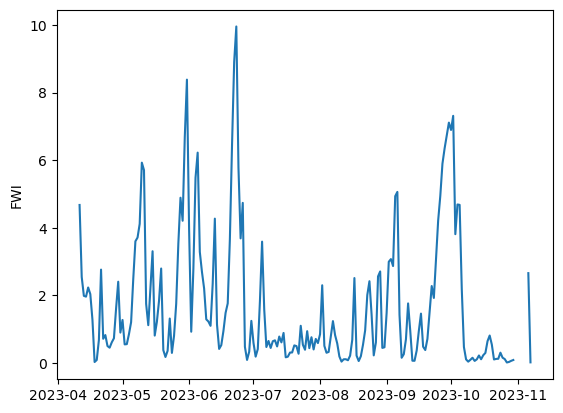

In [86]:
plt.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
plt.ylabel("FWI")

Text(0, 0.5, 'FWI')

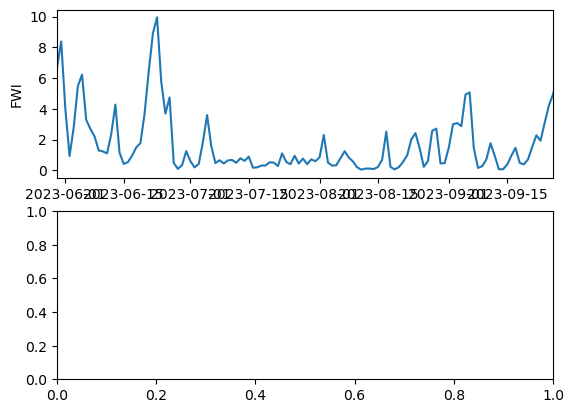

In [87]:
fig, (ax, ax2) = plt.subplots(2)
ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax.set_ylabel("FWI")

In [88]:
no_dupes.columns

Index(['fireID', 'level_1', 'pretty_date_format', 'farea_diff',
       'log_difference', 't', 'lat_centroid'],
      dtype='object')

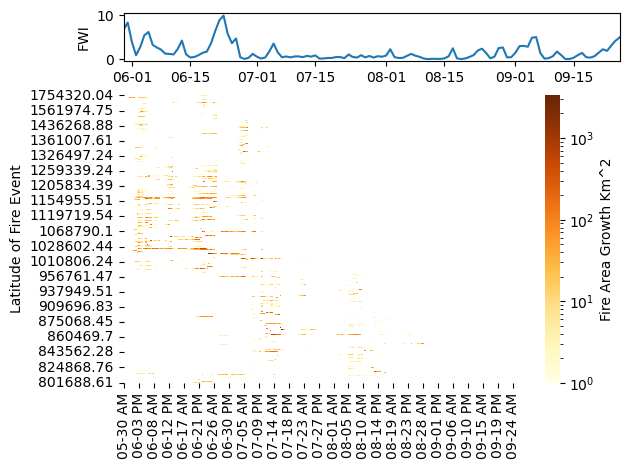

In [89]:
import matplotlib.dates as mdates

fig, (ax, ax2) = plt.subplots(2, gridspec_kw={'height_ratios': [1, 6]})
#fig.suptitle('Aligning x-axis using sharex')
ax2 = sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, fmt='.1f')#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax.set_ylabel("FWI")
plt.savefig('Regional_fire_growth_FWI.png')

In [90]:
# dates = heat.columns.values.astype('datetime64[ns]')
# dates.values.astype('datetime64[ns]')

dates = no_dupes['t'].astype('datetime64[ns]')
dates = dates.drop_duplicates()
print(len(dates.dt.strftime('%-m-%-d')))
print(len(heat.columns))

239
239


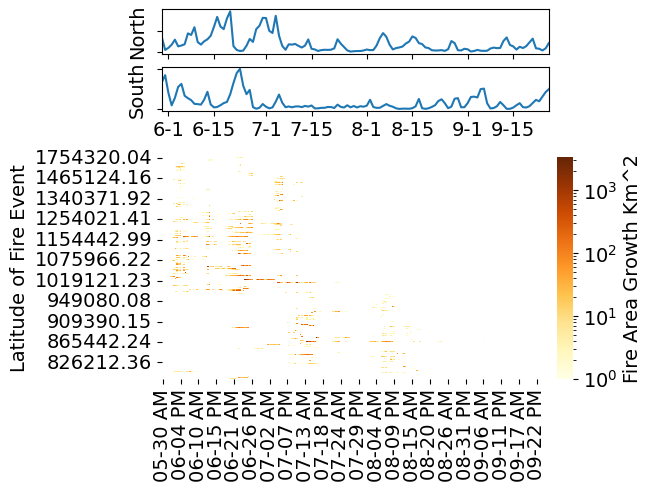

In [91]:
import matplotlib.dates as mdates
import matplotlib as mpl
# fig, ax  = plt.subplots(2, 2, sharex='col', gridspec_kw={'width_ratios':[100,5]})
# ax[0,1].remove()  # remove unused upper right axes
# ax[0,0].plot(x+0.5,L_1,'-', marker='o',color='tab:orange')
# sn.heatmap(M_1, cmap=cmap, vmax=np.max(M_1), center=np.max(M_1)/2., square=False, ax=ax[1,0], cbar_ax=ax[1,1])

#plt.style.use('dark_background')
with mpl.rc_context({'font.size': 14}):
    fig, ([ax, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3,2, gridspec_kw={'width_ratios':[100,4], 'height_ratios': [1,1, 5]}, constrained_layout=True)
    #fig.suptitle('Aligning x-axis using sharex')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    ax.plot(fwin.INITDATE.astype("datetime64[ns]"),fwin.GEOS_5)
    ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
    ax.set_ylabel("North")
    ax.set_xticklabels("")
    ax.set_yticklabels("")


    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax3.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
    ax3.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
    ax3.set_ylabel("South")
    ax3.set_yticklabels("")



    #ax3 = 
    sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    ax5.set(xlabel="", ylabel="Latitude of Fire Event")
    ax2.remove()
    ax4.remove()

    #plt.gcf().subplots_adjust(bottom=0.15)
    #plt.tight_layout()
    #plt.show()
    plt.savefig('Regional_fire_growth_FWI.png', dpi = 900, transparent = False)

In [42]:
#plt.savefig?

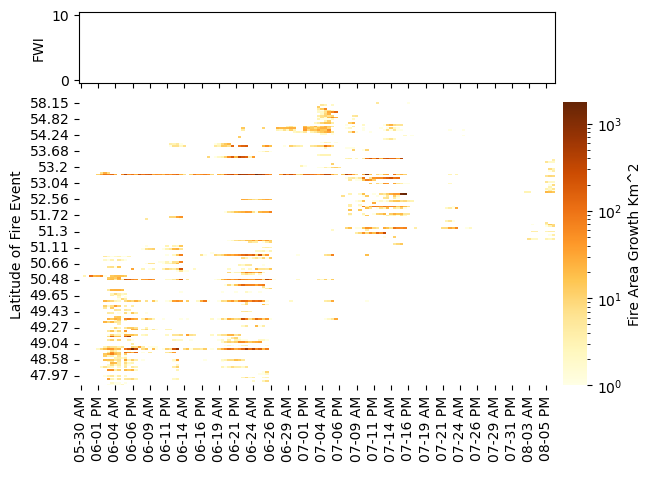

In [43]:


fig, ax  = plt.subplots(2, 2, sharex='col', gridspec_kw={'width_ratios':[100,5], 'height_ratios': [1, 4]}, constrained_layout=True)
  # remove unused upper right axes

ax[0,0].plot(fwis.INITDATE.astype("datetime64[ns]"), fwis.GEOS_5)
ax[0,0].set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax[0,0].set_ylabel("FWI")
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, fmt='.1f', square=False, ax=ax[1,0], cbar_ax=ax[1,1])
ax[1,0].set_ylabel("Latitude of Fire Event")
ax[1,0].set_xlabel(" ")

ax[0,1].remove()



In [ ]:
plt.plot(fwis.INITDATE.astype("datetime64[ns]"), fwis.GEOS_5)

In [ ]:
plt.plot(fwin.INITDATE.astype("datetime64[ns]"), fwin.GEOS_5)

In [ ]:
### Tess trying to make equivilant plot but using FWI instead of fire area

## SEEMS LIKE THE COLORS SCALE A LITTLE BIT DIFFERENLTLY, MONSTER FIRE SCALED DOWN? NOT THERE???? 

#path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Quebec_only_GRIDDED_20_days_BOREAL_NRT_3571_DPSgridded20240122.csv" ## looking for lightning 20 days before start
path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Final_dataset_as_of_20240209.csv"

fire2 = fv.prep_fire_files(path)
fire_tmp = fire2

In [ ]:
fire_tmp.fireID.unique()

In [ ]:
fire_id = fire_tmp[fire_tmp.fireID == '8553']
fire_id.t = fire_id.t.astype('datetime64[ns]')
fire_id = fire_id.sort_values(by = ["fireID", "t"])
plt.plot(fire_id.t, fire_id.FWI)
print(min(fire_id.t))
print(max(fire_id.t))

In [ ]:
fire2 = fire2[~fire2.geometry.isna()]

fire2 = fire2.sort_values(by = ["fireID", "t"])
fire2.farea = fire2.farea.astype("int64")
fire2["farea_diff"] = fire2.groupby("fireID").farea.diff()

fire2.t[~fire2.t.str.contains(".000")] = fire2.t[~fire2.t.str.contains(".000")] + ".000"

In [ ]:
fire2["pretty_date_format"] = fire2.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
no_dupes = fire2[["fireID", "pretty_date_format", "farea_diff", "lat_centroid", "t"]]
no_dupes = no_dupes.dropna()
no_dupes = no_dupes.drop_duplicates(subset = ["fireID", "t"])
no_dupes["log_difference"] = np.log(no_dupes.farea_diff)
lats = no_dupes.groupby("fireID").lat_centroid.mean().reset_index()


from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

no_dupes = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'log_difference', 't']].merge(lats, on = ["fireID"])

#heat = no_dupes.pivot(index =["fireID", "lat_centroid"],  columns=["pretty_date_format"], values="farea_diff")
heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff")

heat = heat.sort_values(by = "lat_centroid", ascending= False)
heat.index = heat.index.astype("float64")

heat.index = heat.index.values.round(2)

In [ ]:
#fire3

In [ ]:
# #path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/againQuebec_only_GRIDDED_20_days_BOREAL_NRT_3571_DPSgridded20240122.csv" 
# path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Final_dataset_as_of_20240209.csv"
# fire3 = fv.prep_fire_files(path)
# fire3 = fire3[~fire3.geometry.isna()]

# fire3 = fire3.sort_values(by = ["fireID", "t"])
# fire3.farea = fire3.farea.astype("int64")
# fire3["farea_diff"] = fire3.groupby("fireID").farea.diff()

# fire3.t[~fire3.t.str.contains(".000")] = fire3.t[~fire3.t.str.contains(".000")] + ".000"

In [ ]:
# fire3["pretty_date_format"] = fire3.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
# no_dupes = fire3[["fireID", "pretty_date_format", "farea_diff", "lat_centroid", "t"]]
# no_dupes = no_dupes.dropna()
# no_dupes = no_dupes.drop_duplicates(subset = ["fireID", "t"])
# no_dupes["log_difference"] = np.log(no_dupes.farea_diff)
# lats = no_dupes.groupby("fireID").lat_centroid.mean().reset_index()


# from matplotlib.colors import LogNorm, Normalize
# from matplotlib.ticker import MaxNLocator

# no_dupes = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'log_difference', 't']].merge(lats, on = ["fireID"])

# #heat = no_dupes.pivot(index =["fireID", "lat_centroid"],  columns=["pretty_date_format"], values="farea_diff")
# heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff")

# heat = heat.sort_values(by = "lat_centroid", ascending= False)
# heat.index = heat.index.astype("float64")

# heat.index = heat.index.values.round(2)

In [ ]:
import matplotlib.dates as mdates
import seaborn as sn

fig, (ax, ax2) = plt.subplots(2, gridspec_kw={'height_ratios': [1, 6]})
#fig.suptitle('Aligning x-axis using sharex')
ax2 = sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, fmt='.1f')#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax.set_ylabel("FWI")
plt.savefig('Regional_fire_growth_FWI.png')

In [ ]:
# ## Try with FWI:
#fire_tmp[fire_tmp.t == "2023-11-27 12:00:00"]
#fire_tmp[fire_tmp.t.str.contains("12:00:00") & (~fire_tmp.t.str.contains(".000"))]

## Lightning timestamps at higher resolution, trying to drop just them

fire_tmp = fire_tmp[fire_tmp.InterCloud.isnull()]

# fire_id = fire_tmp[fire_tmp.fireID == '8553']
# fire_id.t = fire_id.t.astype('datetime64[ns]')
# fire_id = fire_id.sort_values(by = ["fireID", "t"])
# plt.plot(fire_id.t, fire_id.FWI)
# print(min(fire_id.t))
# print(max(fire_id.t))

In [ ]:
# mask = fire_tmp.t.str.contains("12:00:00") & (~fire_tmp.t.str.contains(".000"))
# # mask = ~fire_tmp.t.str.contains(".")
# fire_tmp.loc[mask, "t"] = fire_tmp.loc[mask, "t"] + ".000"
# #fire_tmp.loc[mask, "t"]

mask = fire_tmp.t.str.contains("0.0")
# mask = ~fire_tmp.t.str.contains(".")
fire_tmp.loc[~mask, "t"] = fire_tmp.loc[~mask, "t"] + ".000"
#fire_tmp.loc[mask, "t"]
fire_tmp[~fire_tmp.t.str.contains("0.0")].t.unique()

# fire_id = fire_tmp[fire_tmp.fireID == '8553']
# fire_id.t = fire_id.t.astype('datetime64[ns]')
# fire_id = fire_id.sort_values(by = ["fireID", "t"])
# plt.plot(fire_id.t, fire_id.FWI)
# print(min(fire_id.t))
# print(max(fire_id.t))

In [ ]:
mask = fire_tmp.t.str.contains("0.000")
fire_tmp.loc[~mask, "t"] = fire_tmp.loc[~mask, "t"] + ".000"
fire_tmp[~fire_tmp.t.str.contains("0.000")].t.unique()

# fire_id = fire_tmp[fire_tmp.fireID == '8553']
# fire_id.t = fire_id.t.astype('datetime64[ns]')
# fire_id = fire_id.sort_values(by = ["fireID", "t"])
# plt.plot(fire_id.t, fire_id.FWI)
# print(min(fire_id.t))
# print(max(fire_id.t))

In [ ]:
fire_tmp[fire_tmp.t.str.contains("12:00:00")].t.unique()
fire_tmp[~fire_tmp.t.str.contains("0.000")].t.unique()

In [ ]:
#fire_tmp["max_t"] = fire_tmp.groupby('fireID').t.max()



fire_id = fire_id.to_crs("4326")
fire_id[['fireID', 't', 'lat_centroid']]
foo = get_centroid(fire_id)
foo[['fireID', 't', 'lat_centroid']]

In [ ]:
# fire_tmp = fire_tmp.to_crs("4326")
# test = fire_tmp.groupby(['fireID']).apply(get_centroid)
# test

In [ ]:
test = test.reset_index(drop = True)

In [ ]:
fire_tmp = test

fire_id = fire_tmp[fire_tmp.fireID == '8553']
fire_id.t = fire_id.t.astype('datetime64[ns]')
fire_id = fire_id.sort_values(by = ["fireID", "t"])
plt.plot(fire_id.t, fire_id.FWI)
print(min(fire_id.t))
print(max(fire_id.t))

In [ ]:
#fire_tmp.loc[~fire_tmp.t.str.contains("."), ["t"]] = fire_tmp.t[~fire_tmp.t.str.contains("."), ["t"]] + ".000"

#fire_tmp.t[~fire_tmp.t.str.contains(".")] = fire_tmp.t[~fire_tmp.t.str.contains(".")] + ".000"
#fire_tmp.t[fire_tmp.t ==  "2023-11-27 12:00:00"] = "2023-11-27 12:00:00" + ".000"
#fire_tmp[fire_tmp.t.str.contains("12:00:00") & (~fire_tmp.t.str.contains(".000"))].t = fire_tmp[fire_tmp.t.str.contains("12:00:00") & (~fire_tmp.t.str.contains(".000"))].t.astype('str') + '.000'

fire_tmp["pretty_date_format"] = fire_tmp.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
#no_dupes2 = fire_tmp[["fireID", "pretty_date_format", "FWI", "lat_centroid", "t"]]
#no_dupes2 = no_dupes2.dropna()
#no_dupes2 = no_dupes2.drop_duplicates(subset = ["fireID", "t"])
no_dupes2 = fire_tmp[["fireID", "pretty_date_format", "FWI", "lat_centroid", "t"]]
no_dupes2 = no_dupes2.dropna()
#no_dupes2 = no_dupes2.drop_duplicates(subset = ["lat_centroid", "pretty_date_format"])
no_dupes2 = no_dupes2.drop_duplicates(subset = ["fireID", "t"])

In [ ]:
#no_dupes2.lat_centroid[0]
#no_dupes2[no_dupes2.lat_centroid == 52.516399]
no_dupes2[no_dupes2.lat_centroid == 52.516399219991065].FWI.unique()
plt.plot(no_dupes2[no_dupes2.lat_centroid == 52.516399219991065].pretty_date_format, no_dupes2[no_dupes2.lat_centroid == 52.516399219991065].FWI)
print(min(no_dupes2[no_dupes2.lat_centroid == 52.516399219991065].pretty_date_format))
print(max(no_dupes2[no_dupes2.lat_centroid == 52.516399219991065].pretty_date_format))

In [ ]:
lats2 = no_dupes2.groupby("fireID").lat_centroid.mean().reset_index()


from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

no_dupes2 = no_dupes2[['fireID', 'pretty_date_format', "FWI", 't']].merge(lats2, on = ["fireID"])

#heat = no_dupes.pivot(index =["fireID", "lat_centroid"],  columns=["pretty_date_format"], values="farea_diff")
heat2 = no_dupes2.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="FWI")

heat2 = heat2.sort_values(by = "lat_centroid", ascending= False)

heat2.index = heat2.index.astype("float64")
heat2.index = heat2.index.values.round(2)

In [ ]:
#len(heat2.index.values.astype("float64"))

In [ ]:
#fire2[["fireID", "pretty_date_format", "FWI", "lat_centroid", "t"]].dropna()

In [ ]:
import matplotlib.dates as mdates
import seaborn as sn

fig, (ax, ax2) = plt.subplots(2, gridspec_kw={'height_ratios': [1, 6]})
#fig.suptitle('Aligning x-axis using sharex')
ax2 = sn.heatmap(heat2, cmap = "cool", cbar_kws={'label': 'Fire Weather Index'}, fmt='.1f')#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax.set_ylabel("FWI")


In [ ]:
#heat2.index[(heat2.index > 52.52) & (heat2.index < 53.03)] #53.01, 52.95, 52.95, 52.92 ,52.9, 52.9

heat2[heat2.index == 52.92].dropna(axis = 1)

In [ ]:
no_dupes2[(no_dupes2.lat_centroid > 52.90) & (no_dupes2.lat_centroid < 52.95)]

In [ ]:
### Check differences in the two "fire" objects

fires[fires.farea == fires.farea.max()].fireID.unique()

In [ ]:
#fire2[fire2.farea == fire2.farea.max()].fireID.unique()

In [ ]:
#fire2[fire2.fireID == "8495"] ## That ID is missing, WHY? Merged into new? Butthe fire2 fire is smaller. 

In [ ]:
fires[fires.farea == fires.farea.max()].farea.unique()

In [ ]:
fire3[fire3.farea == fire3.farea.max()].fireID.unique()

In [ ]:
print("IDS in fires but not in fire3", fires[~fires.fireID.isin(fire3.fireID)].fireID.unique())
print("______________________")
print("IDS in fire3 but not in fires", fire3[~fire3.fireID.isin(fires.fireID)].fireID.unique())
print("______________________")
print("IDS in fires but not in fire2", fires[~fires.fireID.isin(fire2.fireID)].fireID.unique())
print("______________________")
print("IDS in fire2 but not in fire3", fire2[~fire2.fireID.isin(fire3.fireID)].fireID.unique())
print("______________________")
print("IDS in fire3 but not in fire2", fire3[~fire3.fireID.isin(fire2.fireID)].fireID.unique())



In [ ]:
## Check if any of the fire objects have the same IDS as the IDS fed into the for loop

def lf_ids(year = None, regnm = 'BOREAL_NRT_3571_DPS'):
    
    diroutdata = "s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/"

    if year == None:
        year = date.today().year

    if diroutdata.startswith("s3://"):
        # Can't use glob for S3. Use s3.ls instead.
        s3 = s3fs.S3FileSystem(anon=False)
        s3path = os.path.join(diroutdata, regnm, str(year), "Largefire")
        fnms = [f for f in s3.ls(s3path)]


    fnms.sort()
    ids = []
    for f in fnms:
        fnm_lts = os.path.basename(f) 
        one_id = fnm_lts[1:-11]
        ids.append(one_id)
    tmp_ids = pd.DataFrame(ids, columns=["ids"])
    tmp_ids = tmp_ids.ids.unique()
    return(tmp_ids)

def unique(list1):
 
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    return(unique_list)

def get_listed_ids(quebec_stats):
    newlist = [x.strip('][\n').split(' ') for x in quebec_stats.fireID.unique()]
    newlist = list(chain(*newlist))
    newlist = [x.replace('\n', ' ') for x in newlist]
    newlist = unique(newlist)
    return(newlist)

def concat_subsets(files):
    df = []
    for f in files:
        #manyfr = pd.read_csv(f, parse_dates=['t'], date_parser=dateparse)
        manyfr = pd.read_csv(f)
        manyfr = gpd.GeoDataFrame(manyfr)
        
        
        manyfr.t[~manyfr.t.str.contains("12:00:00")] = manyfr.t[~manyfr.t.str.contains("12:00:00")] + " 00:00:00"
        #print(manyfr.t[~manyfr.t.str.contains("12:00:00")])
        
        manyfr.t = manyfr.t.astype("datetime64[ns]")
        #manyfr.t = manyfr.t.astype("str")

        
        #manyfr.t.tz("UCT")
        df.append(manyfr)
    df = pd.concat(df)
    #df.t = df.t.astype("datetime64[ns]")
    return(df)


In [ ]:
files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats//boreal_snapstats*.csv")


fire_stats = concat_subsets(files)

fire_stats.t.max()

### Subsetting fire stats by largefire record, so don't waste time looking for IDs that we haven't got yet. Wait, not worth it, size a bigger thing anyway.
#fire_stats = fire_stats[fire_stats.t < "2023-07-20 12:00:00"]

#fire_stats = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/boreal_snapstats_20231024.csv")

quebec_stats = fire_stats[fire_stats.prov_name_en == "Quebec"]

tmp_list = get_listed_ids(quebec_stats)

ids_lf = lf_ids( year = "2023")

tmp_list = list(set(tmp_list).intersection(ids_lf))

In [ ]:
print("IDS in fires but not in tmp_list", fires[~fires.fireID.isin(tmp_list)].fireID.unique())
print("______________________")
print("IDS in fire3 but not in tmp_list", fire3[~fire3.fireID.isin(tmp_list)].fireID.unique())
print("______________________")
print("IDS in fire2 but not in tmp_list", fire2[~fire2.fireID.isin(tmp_list)].fireID.unique())
print("______________________")




In [ ]:
set(tmp_list).symmetric_difference(fire3.fireID.unique())

In [ ]:
set([1,2,3,4]).symmetric_difference([1,2])

In [ ]:
set([1,2]).symmetric_difference([1,2,3,4])

In [ ]:
fire3[fire3.fireID == '8553']

In [ ]:
len(fire3.fireID.unique())